In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
sns.set_theme(style="ticks", color_codes=True)

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
categorical_data = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                    'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod']

In [7]:
df = df.drop(columns=['customerID'])

### Кол-во уникальных значений во всех признаках
#### Если значений 50 и больше, то отрисуем, что их 100 (для наглядности)

<AxesSubplot:>

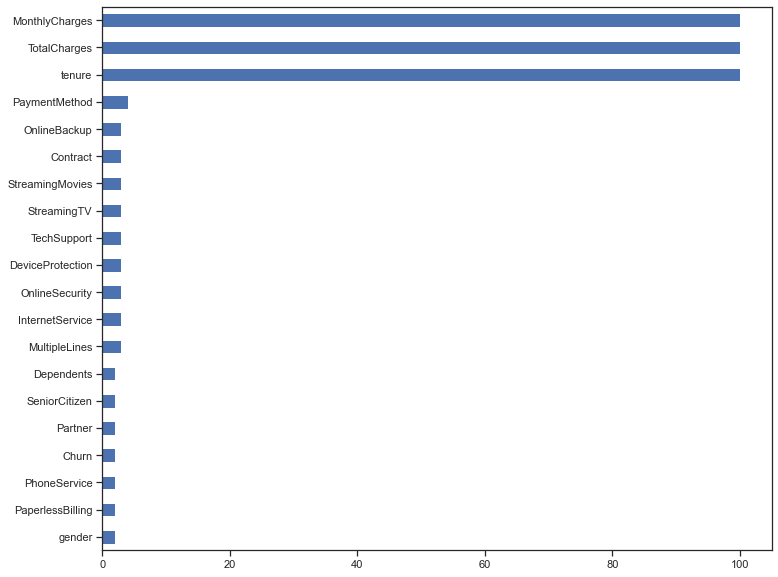

In [8]:
df.apply(lambda x: x.nunique() if x.nunique() < 50 else 100).sort_values().plot.barh(figsize=(12, 10))

#### Делаем вывод, что первые 4 переменные почти на верняка не являются категориальными 

### Обзор категориальных признаков

#### График целевой переменной

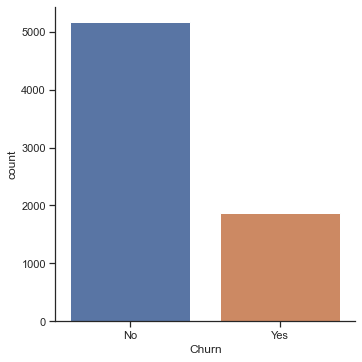

In [9]:
sns.catplot(x='Churn', kind='count', data=df)

#### Посмотрим на все категориальный признаки

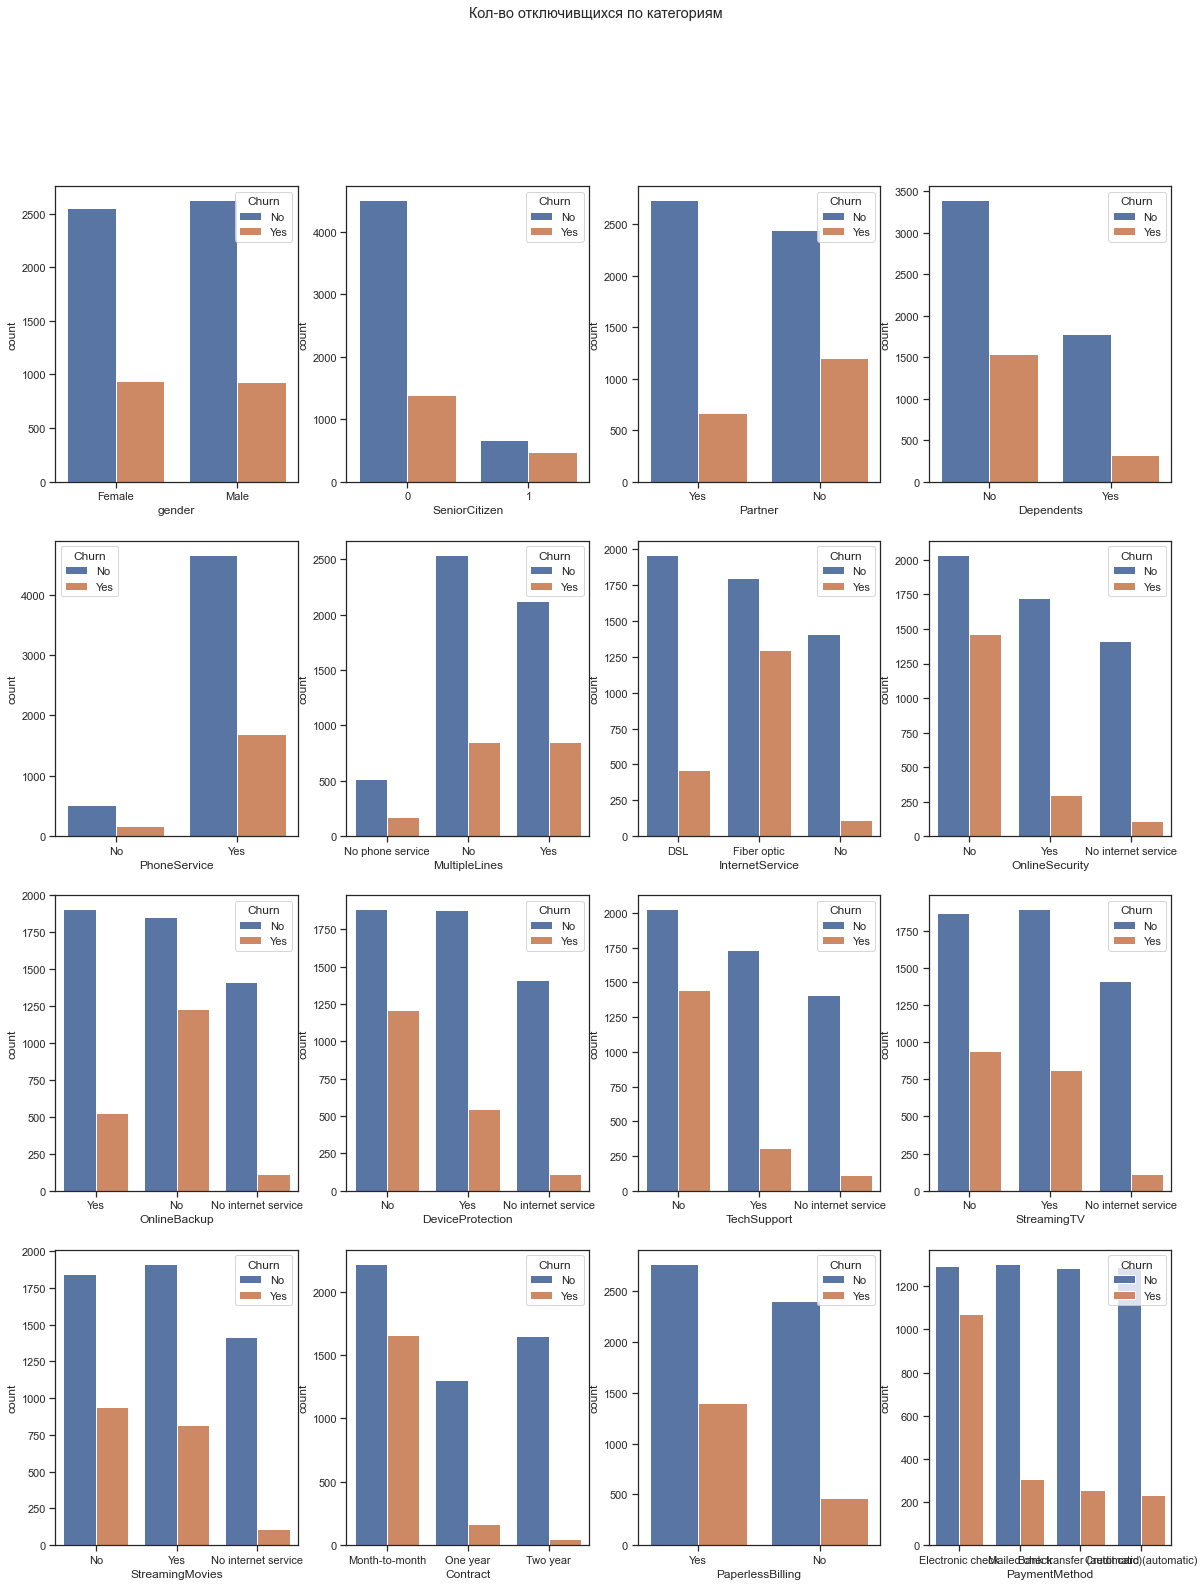

In [10]:
fig, ax = plt.subplots(4, 4, figsize=(20, 25))
axes_to_plot = [(i, j) for i in range(4) for j in range(4)]
fig.suptitle('Кол-во отключивщихся по категориям')
for i, column in enumerate(categorical_data):
    sns.countplot(x=column, hue='Churn', data=df, ax=ax[axes_to_plot[i]])

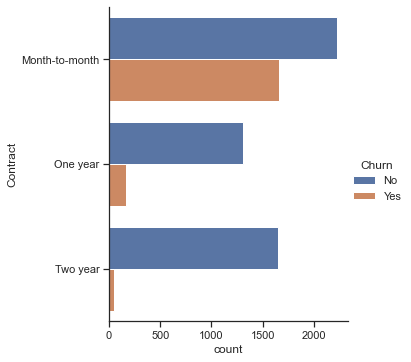

In [11]:
# Забавно что уходят в основном пользователя у которые месячный контракт.
# Те, у кого контракт на год или два не так стемительно покидают компанию.

sns.catplot(y='Contract', hue='Churn', kind='count', data=df)

In [12]:
set(df.columns) - set(categorical_data)

{'Churn', 'MonthlyCharges', 'TotalCharges', 'tenure'}

### Обработка числовых признаков

#### Убираем пустые значения в "TotalCharges"

In [13]:
df[['TotalCharges']].isna().any()

TotalCharges    False
dtype: bool

In [14]:
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: np.nan if x == ' ' else x)

In [15]:
df = df.loc[~df['TotalCharges'].isna()]

In [16]:
df['TotalCharges'] = df['TotalCharges'].astype('float')

<ipython-input-16-cadf4347bbaa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalCharges'] = df['TotalCharges'].astype('float')


### Применяем One-Hot для категориальных признаков

In [17]:
for categorical_column in categorical_data:
    df = pd.get_dummies(df, columns=[categorical_column], prefix=categorical_column.lower(), drop_first=True)

In [18]:
df.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender_Male',
       'seniorcitizen_1', 'partner_Yes', 'dependents_Yes', 'phoneservice_Yes',
       'multiplelines_No phone service', 'multiplelines_Yes',
       'internetservice_Fiber optic', 'internetservice_No',
       'onlinesecurity_No internet service', 'onlinesecurity_Yes',
       'onlinebackup_No internet service', 'onlinebackup_Yes',
       'deviceprotection_No internet service', 'deviceprotection_Yes',
       'techsupport_No internet service', 'techsupport_Yes',
       'streamingtv_No internet service', 'streamingtv_Yes',
       'streamingmovies_No internet service', 'streamingmovies_Yes',
       'contract_One year', 'contract_Two year', 'paperlessbilling_Yes',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')

### --> Кодируем целевую метку в булеву переменную

In [19]:
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == 'No' else 1)

In [20]:
df.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,seniorcitizen_1,partner_Yes,dependents_Yes,phoneservice_Yes,multiplelines_No phone service,...,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,1,29.85,29.85,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,2,70.70,151.65,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


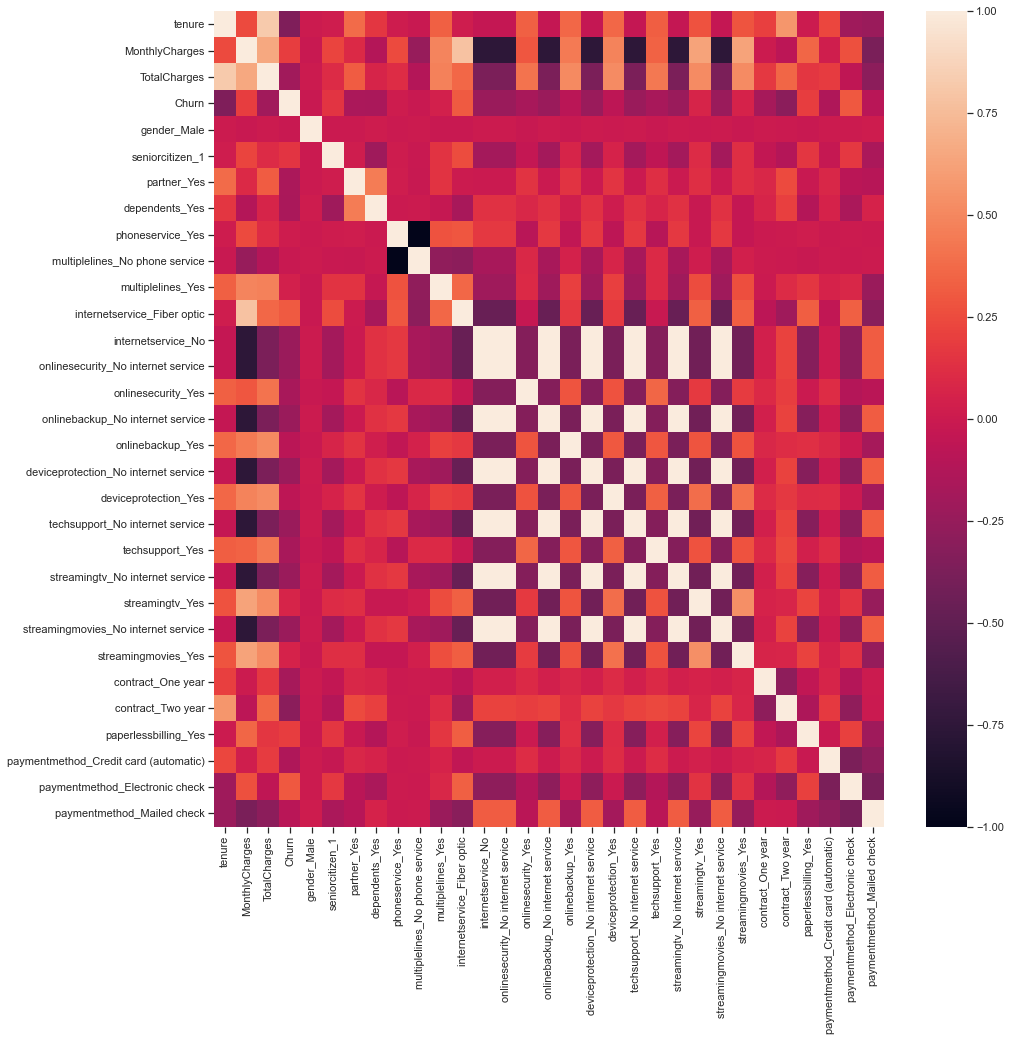

In [21]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr())
plt.show()

## Машинное Обучение

In [22]:
random.seed(42)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Churn']),
    df['Churn'],
    test_size=0.3
)

In [24]:
X_train.shape, X_test.shape

((4922, 30), (2110, 30))

### Scaling

In [25]:
scaler = StandardScaler()

In [26]:
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [27]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_columns] = scaler.fit_transform(X_train_scaled[numeric_columns])
X_test_scaled[numeric_columns] = scaler.transform(X_test_scaled[numeric_columns])

In [28]:
X_train_scaled.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,seniorcitizen_1,partner_Yes,dependents_Yes,phoneservice_Yes,multiplelines_No phone service,multiplelines_Yes,...,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
1242,-0.460805,-1.200936,-0.727137,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
665,-1.193784,0.330691,-0.899486,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
5837,-1.234505,-0.442573,-0.961729,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
1949,1.412363,1.319212,2.028854,1,0,1,1,1,0,1,...,0,1,0,1,0,1,0,0,0,0
3794,-0.990178,-0.331634,-0.807970,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [29]:
y_test.value_counts(normalize=True)

0    0.734123
1    0.265877
Name: Churn, dtype: float64

In [30]:
### Фунуция отрисовка результатов

## KNN

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1549
           1       0.55      0.51      0.53       561

    accuracy                           0.76      2110
   macro avg       0.69      0.68      0.68      2110
weighted avg       0.75      0.76      0.75      2110



<AxesSubplot:>

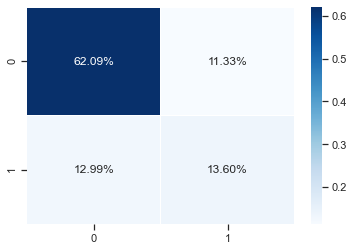

In [31]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)

y_pred = knn_classifier.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

### KNN GridSearchCV

best_score: 0.606, best k: 23, best p: 1
result: 0.576
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1549
           1       0.61      0.55      0.58       561

    accuracy                           0.78      2110
   macro avg       0.72      0.71      0.72      2110
weighted avg       0.78      0.78      0.78      2110



<AxesSubplot:>

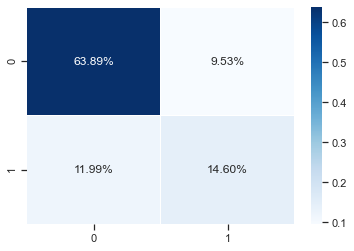

In [32]:
grid_cv_params = {'n_neighbors': range(1, 30),
                  'p': range(1, 3)}

grid_search = GridSearchCV(KNeighborsClassifier(), grid_cv_params, cv=5, scoring='f1', verbose=-1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print('best_score: {:.3f}, best k: {}, best p: {}'
      .format(grid_search.best_score_, grid_search.best_estimator_.n_neighbors, grid_search.best_estimator_.p))

y_pred = grid_search.best_estimator_.predict(X_test_scaled)
print('result: {:.3f}'.format(f1_score(y_pred, y_test)))

report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

## SVM

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1549
           1       0.63      0.52      0.57       561

    accuracy                           0.79      2110
   macro avg       0.73      0.70      0.72      2110
weighted avg       0.78      0.79      0.78      2110



<AxesSubplot:>

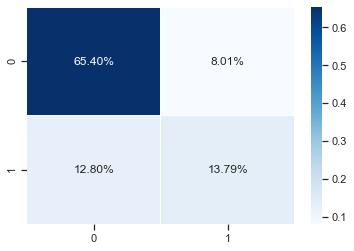

In [33]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_scaled, y_train)

y_pred = svm_classifier.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

### SVM GridSearchCV

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best_score: 0.590, best C: 1000, best gamma: 1, best kernerl: linear
result: 0.571
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1549
           1       0.63      0.52      0.57       561

    accuracy                           0.79      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.78      0.79      0.79      2110



<AxesSubplot:>

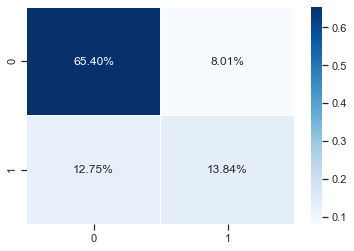

In [34]:
grid_cv_params = {'C': [0.1, 1, 10, 100, 1000],  
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                  'kernel': ['linear', 'rbf']}

grid_search = GridSearchCV(SVC(), grid_cv_params, cv=5, scoring='f1', verbose=10, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print('best_score: {:.3f}, best C: {}, best gamma: {}, best kernerl: {}'
      .format(grid_search.best_score_, grid_search.best_estimator_.C, grid_search.best_estimator_.gamma, grid_search.best_estimator_.kernel))

y_pred = grid_search.best_estimator_.predict(X_test_scaled)
print('result: {:.3f}'.format(f1_score(y_pred, y_test)))

report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

## Tree

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1549
           1       0.51      0.49      0.50       561

    accuracy                           0.74      2110
   macro avg       0.66      0.66      0.66      2110
weighted avg       0.74      0.74      0.74      2110



<AxesSubplot:>

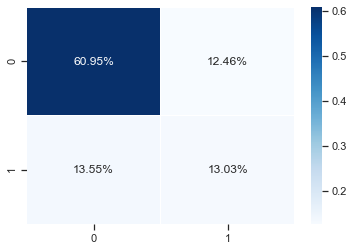

In [35]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train_scaled, y_train)

y_pred = tree_classifier.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

### Tree GridSearchCV

Fitting 5 folds for each of 2352 candidates, totalling 11760 fits
best_score: 0.588, best max_leaf_nodes: 20, best min_samples_split: 2, best max_depth: 6, best criterion: entropy
result: 0.558
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1549
           1       0.61      0.52      0.56       561

    accuracy                           0.78      2110
   macro avg       0.72      0.70      0.71      2110
weighted avg       0.77      0.78      0.78      2110



<AxesSubplot:>

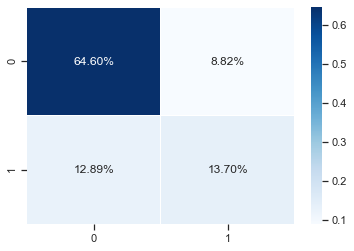

In [36]:
grid_cv_params = {'max_leaf_nodes': list(range(2, 51)),
                  'min_samples_split': [2, 3, 4],  
                  'max_depth': [2, 4, 6, 8, 10, 20, 50, 100], 
                  'criterion': ['gini', 'entropy']}

grid_search = GridSearchCV(DecisionTreeClassifier(), grid_cv_params, cv=5, scoring='f1', verbose=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print('best_score: {:.3f}, best max_leaf_nodes: {}, best min_samples_split: {}, best max_depth: {}, best criterion: {}'
      .format(grid_search.best_score_, grid_search.best_estimator_.max_leaf_nodes, grid_search.best_estimator_.min_samples_split, grid_search.best_estimator_.max_depth, grid_search.best_estimator_.criterion))

y_pred = grid_search.best_estimator_.predict(X_test_scaled)
print('result: {:.3f}'.format(f1_score(y_pred, y_test)))

report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

## Random Forest

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1549
           1       0.63      0.44      0.52       561

    accuracy                           0.78      2110
   macro avg       0.72      0.67      0.69      2110
weighted avg       0.77      0.78      0.77      2110



<AxesSubplot:>

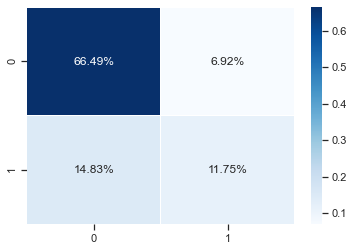

In [37]:
forest_classifier = RandomForestClassifier()
forest_classifier.fit(X_train_scaled, y_train)

y_pred = forest_classifier.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

### Random Forest GridSearchCV

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
best_score: 0.593, best bootstrap: True, best min_samples_split: 4, best max_depth: 10, best max_features: sqrt, best min_samples_leaf: 2, best n_estimators: 200, best criterion: gini
result: 0.556
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1549
           1       0.65      0.48      0.56       561

    accuracy                           0.79      2110
   macro avg       0.74      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110



<AxesSubplot:>

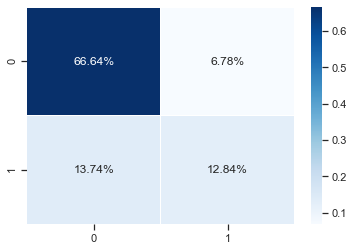

In [38]:
grid_cv_params = {'bootstrap': [True, False],
                  'max_depth': [2, 4, 5, 10, 20, 50, None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [1, 2, 4],
                  'min_samples_split': [2, 4],
                  'criterion': ['gini', 'entropy'],
                  'n_estimators': [50, 100, 150, 200]}

grid_search = GridSearchCV(RandomForestClassifier(), grid_cv_params, cv=5, scoring='f1', verbose=10, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print('best_score: {:.3f}, best bootstrap: {}, best min_samples_split: {}, best max_depth: {}, best max_features: {}, best min_samples_leaf: {}, best n_estimators: {}, best criterion: {}'
      .format(grid_search.best_score_, grid_search.best_estimator_.bootstrap, grid_search.best_estimator_.min_samples_split, grid_search.best_estimator_.max_depth, 
              grid_search.best_estimator_.max_features, grid_search.best_estimator_.min_samples_leaf, grid_search.best_estimator_.n_estimators, grid_search.best_estimator_.criterion))

y_pred = grid_search.best_estimator_.predict(X_test_scaled)
print('result: {:.3f}'.format(f1_score(y_pred, y_test)))

report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

## Logistic Regression

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1549
           1       0.64      0.52      0.57       561

    accuracy                           0.79      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.78      0.79      0.79      2110



<AxesSubplot:>

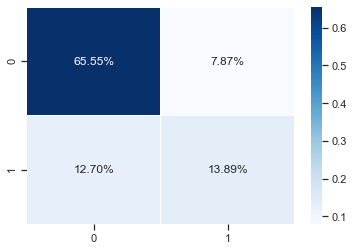

In [39]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_scaled, y_train)

y_pred = lr_classifier.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

### Logistic Regression GridSearchCV

Fitting 5 folds for each of 80 candidates, totalling 400 fits
best_score: 0.605, best penalty: l2, best C: 5
result: 0.571
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1549
           1       0.64      0.52      0.57       561

    accuracy                           0.79      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.78      0.79      0.79      2110



/home/kostya/PycharmProjects/venvs/otus_course/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.                nan 0.         0.09482411
 0.09482411 0.39171396 0.09482411 0.09482411        nan        nan
 0.49683252        nan 0.45991088 0.55213553 0.55213553 0.56551546
 0.55213553 0.55213553        nan        nan 0.50765739        nan
 0.48312685 0.55684694 0.55684694 0.5686427  0.55684694 0.55684694
        nan        nan 0.59313603        nan 0.58551161 0.59760987
 0.59760987 0.5967907  0.59760987 0.59760987        nan        nan
 0.59879238        nan 0.60038568 0.60217217 0.60217217 0.60083338
 0.60217217 0.60217217        nan        nan 0.60384956        nan
 0.60459119 0.60488963 0.60488963 0.60519002 0.60488963 0.60459119
        nan        nan 0.60433825        nan 0.60433825 0.6020021
 0.60225359 0.60488963 0.60318241 0.60488963        nan        nan
 0.60343779        nan

<AxesSubplot:>

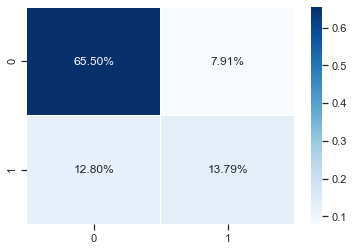

In [40]:
grid_cv_params = {'penalty': ['l1', 'l2'],
                  'C':[0.001,.009,0.01,.09,1,5,10,25],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid_search = GridSearchCV(LogisticRegression(), grid_cv_params, cv=5, scoring='f1', verbose=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print('best_score: {:.3f}, best penalty: {}, best C: {}'
      .format(grid_search.best_score_, grid_search.best_estimator_.penalty, grid_search.best_estimator_.C))

y_pred = grid_search.best_estimator_.predict(X_test_scaled)
print('result: {:.3f}'.format(f1_score(y_pred, y_test)))

report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

## XGBoost

[19:44:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1549
           1       0.62      0.49      0.55       561

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.78      2110



<AxesSubplot:>

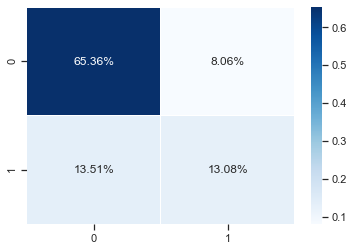

In [41]:
xgb_classifier = XGBClassifier(use_label_encoder=False)
xgb_classifier.fit(X_train_scaled, y_train)

y_pred = xgb_classifier.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

### XGBoost GridSearchCV

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[20:08:00] WARNING: ../src/learner.cc:541: 
Parameters: { n_components } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:08:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
result: 0.553
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1549
           1       0.63      0.49      0.55       561

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.71      2110
weighted avg       0.78      0.79      0.78      2110



<AxesSubplot:>

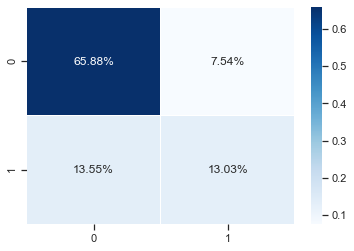

In [42]:
grid_cv_params = {'n_components': [5, 10, 15, 20, 25, 30],
                 'max_depth': [2, 3, 5, 7, 10],
                 'n_estimators': [10, 100, 500]}


grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False), grid_cv_params, cv=5, scoring='f1', verbose=10, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# print('best_score: {:.3f}, best n_components: {}, best max_depth: {}, best n_estimators: {}'
#       .format(grid_search.best_score_, grid_search.best_estimator_.n_components, grid_search.best_estimator_.max_depth, grid_search.best_estimator_.n_estimators))

y_pred = grid_search.best_estimator_.predict(X_test_scaled)
print('result: {:.3f}'.format(f1_score(y_pred, y_test)))

report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)

## CatBoost

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1549
           1       0.61      0.43      0.50       561

    accuracy                           0.77      2110
   macro avg       0.71      0.66      0.68      2110
weighted avg       0.76      0.77      0.76      2110



<AxesSubplot:>

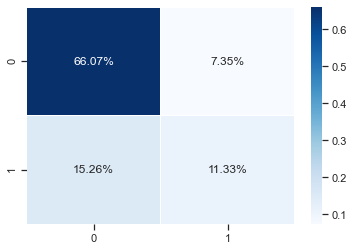

In [43]:
catb_classifier = CatBoostClassifier(iterations=2, learning_rate=1, depth=2, verbose=0)
catb_classifier.fit(X_train_scaled, y_train)

y_pred = catb_classifier.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax, linewidths=.5)